## Import thư viện

Trong bước đầu tiên, nhóm tiến hành import toàn bộ các thư viện cần thiết để xử lý dữ liệu, trực quan hóa và xây dựng mô hình học máy. Các thư viện chính bao gồm:
- pandas, numpy: xử lý dữ liệu dạng bảng và tính toán số.
- matplotlib, seaborn: trực quan hóa dữ liệu.
- scikit-learn: tách dữ liệu, mô hình Random Forest, tối ưu và đánh giá.
- scipy.stats: dùng trong quá trình tuning.

Đây là bộ thư viện tối thiểu để chạy toàn bộ pipeline dự đoán giá xe Audi.

In [12]:
# ============================================================
# BTL CO3117: Dự đoán giá xe Audi đã qua sử dụng
# Thuật toán: Random Forest Regressor
# Nhóm: CO3117
# ============================================================

# --- 1. IMPORT THƯ VIỆN ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
import warnings

# Tắt cảnh báo không cần thiết để code sạch
warnings.filterwarnings("ignore")

## 2. Tải và tiền xử lý dữ liệu

### 2.1. Tải dữ liệu

Dataset được tải từ file audi.csv chứa thông tin về giá xe Audi cũ.

### 2.2. Làm sạch dữ liệu thô

Qua quan sát ban đầu, nhóm phát hiện dữ liệu tồn tại một số điểm “nhiễu”:

- Một số tên cột chứa khoảng trắng thừa.
- Một số giá trị dạng chuỗi (ví dụ model, transmission) cũng có khoảng trắng thừa.

Để đảm bảo dữ liệu nhất quán, nhóm thực hiện:

1. Xóa khoảng trắng thừa ở tên cột bằng df.columns.str.strip().
2. Duyệt qua các cột dạng object và chuẩn hóa lại bằng df[col].str.strip().

Mục tiêu: tránh lỗi trong quá trình one-hot encoding và xử lý sau này.

In [14]:
# ============================================================
# 2. LOAD DỮ LIỆU VÀ TIỀN XỬ LÝ CƠ BẢN
# ============================================================

def load_and_clean_data(filepath):
    """
    Hàm đọc dữ liệu từ file CSV và làm sạch cơ bản.
    - Loại bỏ khoảng trắng thừa ở tên cột và giá trị chuỗi
    - Trả về DataFrame pandas
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: Không tìm thấy file '{filepath}'")
        print("Hãy tải file 'audi.csv' và đặt vào đúng thư mục.")
        return None

    # Làm sạch tên cột
    df.columns = df.columns.str.strip()

    # Làm sạch dữ liệu chuỗi (string)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.strip()

    print("Dữ liệu đã được load và làm sạch thành công.")
    return df

DATA_FILEPATH = "../data/audi.csv"

df = load_and_clean_data(DATA_FILEPATH)

Dữ liệu đã được load và làm sạch thành công.


## 3. Khám phá dữ liệu (EDA)

Sau khi làm sạch, nhóm tiến hành phân tích tổng quan để hiểu rõ dữ liệu:

### 3.1. Thông tin tổng quan (df.info())

- Dataset có ~10,000 mẫu và 9 cột.
- Không có giá trị bị thiếu (non-null).
- Ba cột dạng chữ: model, transmission, fuelType → cần mã hóa.

### 3.2. Phân bố giá xe

Histogram của biến price cho thấy:

- Phân bố lệch phải (right-skewed).
- Đa phần xe có giá dưới 40,000.

### 3.3. Phân tích quan hệ giữa các biến

- Price vs Year: Xe năm càng mới → giá càng cao → tương quan thuận.
- Price vs Mileage: Xe đi càng nhiều → giá càng giảm → tương quan nghịch.

### 3.4. Ma trận tương quan (heatmap)

Kết quả đáng chú ý:

- year ~ price: tương quan dương mạnh (≈0.63).
- mileage ~ price: tương quan âm vừa (-0.40).

Điều này xác nhận 2 đặc trưng quan trọng nhất trong dự đoán giá: năm sản xuất và số km đã đi.


--- 3. EDA: Khám phá dữ liệu ---

5 dòng đầu tiên của dữ liệu:
  model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0    A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4
1    A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0
2    A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4
3    A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0
4    A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax      

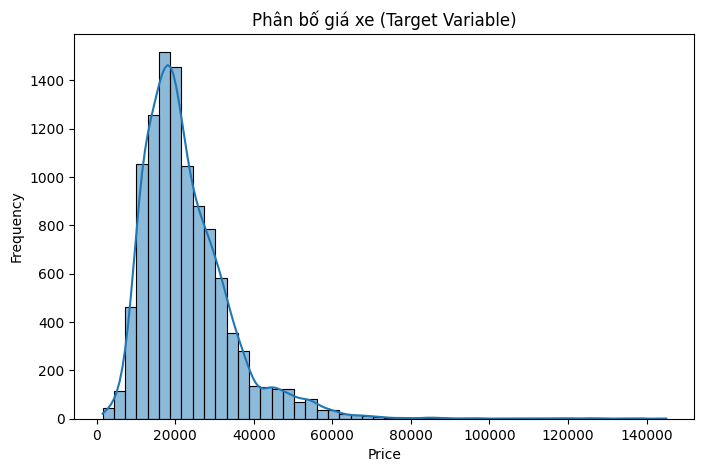

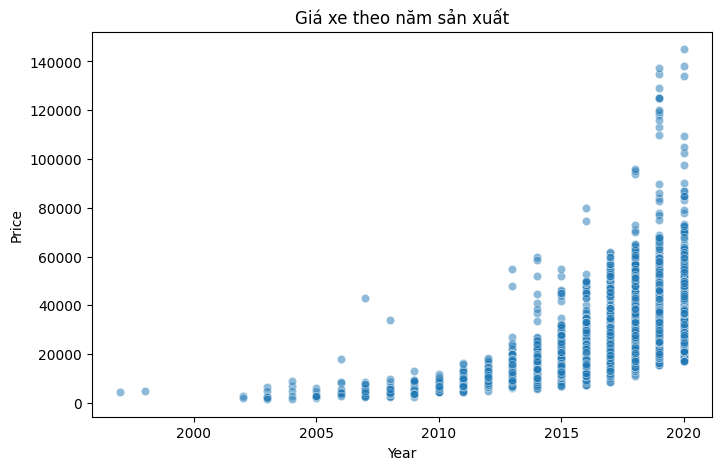

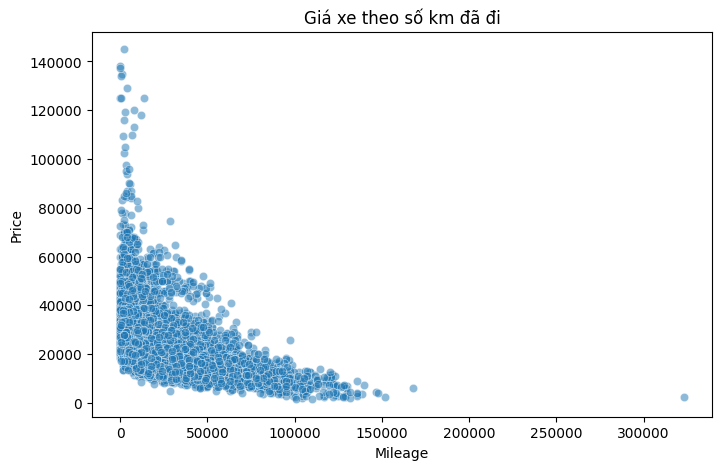


Heatmap tương quan giữa các biến số:


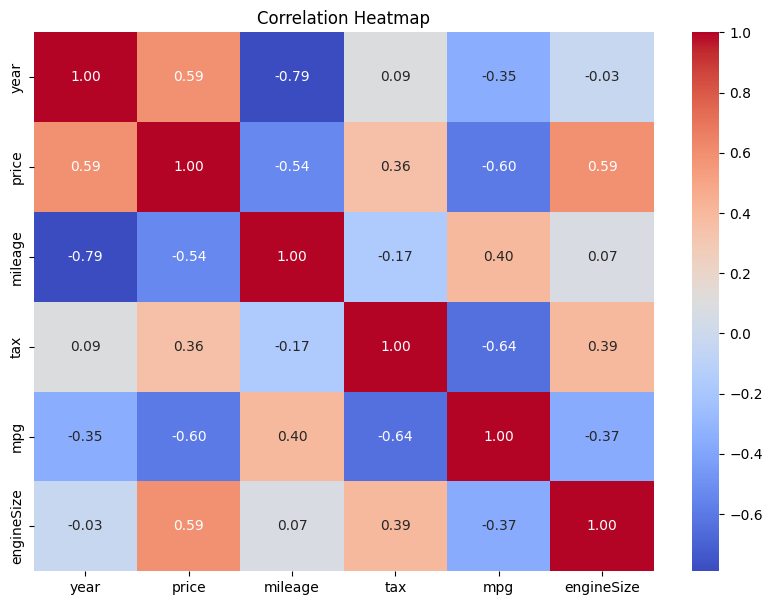

In [15]:
# ============================================================
# 3. KHÁM PHÁ DỮ LIỆU (EDA)
# ============================================================

def run_eda(df):
    """
    Khám phá dữ liệu ban đầu:
    - Thông tin tổng quan
    - Biểu đồ phân bố giá
    - Scatter plots so sánh giá với năm và km đã đi
    - Heatmap ma trận tương quan
    """
    print("\n--- 3. EDA: Khám phá dữ liệu ---")

    # Hiển thị một số dòng đầu
    print("\n5 dòng đầu tiên của dữ liệu:")
    print(df.head())

    # Thông tin tổng quan về dữ liệu
    print("\nThông tin dữ liệu:")
    df.info()

    # Thống kê cơ bản của dữ liệu số
    print("\nThống kê mô tả dữ liệu số:")
    print(df.describe())

    # Phân bố giá
    plt.figure(figsize=(8, 5))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title("Phân bố giá xe (Target Variable)")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.show()

    # Giá vs. Năm sản xuất
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='year', y='price', alpha=0.5)
    plt.title("Giá xe theo năm sản xuất")
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.show()

    # Giá vs. Mileage (số km đã đi)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='mileage', y='price', alpha=0.5)
    plt.title("Giá xe theo số km đã đi")
    plt.xlabel("Mileage")
    plt.ylabel("Price")
    plt.show()

    # Heatmap tương quan giữa các biến số
    print("\nHeatmap tương quan giữa các biến số:")
    plt.figure(figsize=(10, 7))
    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap")
    plt.show()

run_eda(df)

## 4. Tiền xử lý & tạo đặc trưng (Feature Engineering)

Để mô hình có thể đọc dữ liệu dạng chữ, nhóm sử dụng One-Hot Encoding cho 3 cột:
- model
- transmission
- fuelType

Điều này biến dữ liệu dạng chữ thành dữ liệu dạng số (0/1).
Kết quả: số lượng feature tăng từ 9 → hơn 30 cột.

Sau đó dataset được tách thành:
- X: tất cả đặc trưng
- y: biến mục tiêu (price)

In [ ]:
# ============================================================
# 4. TIỀN XỬ LÝ DỮ LIỆU & FEATURE ENGINEERING
# ============================================================

def preprocess_data(df):
    """
    - One-Hot Encoding cho các biến categorical
    - Tách dữ liệu thành X (features) và y (target)
    - Trả về danh sách feature names để phân tích quan trọng đặc trưng
    """
    print("\n--- 4. Tiền xử lý dữ liệu ---")

    categorical_cols = ['model', 'transmission', 'fuelType']

    print(f"Số lượng feature ban đầu: {df.shape[1]}")
    df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"Số lượng feature sau khi one-hot encoding: {df_processed.shape[1]}")

    X = df_processed.drop('price', axis=1)
    y = df_processed['price']

    feature_names = X.columns.tolist()

    return X, y, feature_names

# Tiền xử lý & tạo features
X, y, feature_names = preprocess_data(df)


--- 4. Tiền xử lý dữ liệu ---
Số lượng feature ban đầu: 9
Số lượng feature sau khi one-hot encoding: 35


## 5. Huấn luyện mô hình cơ bản (Base Model)

Nhóm sử dụng Random Forest Regressor với bộ tham số mặc định:
- Số lượng cây: 100
- Không giới hạn độ sâu
- Random state cố định để kết quả reproducible

Mục tiêu của mô hình baseline: Tạo chuẩn so sánh trước khi tuning.

In [ ]:
# ============================================================
# 5. TRAIN BASE MODEL & EVALUATE
# ============================================================

def train_base_model(X_train, y_train):
    """
    Huấn luyện Random Forest cơ bản với tham số mặc định.
    """
    print("\n--- 5. Huấn luyện Base Random Forest ---")
    rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
    print("Đang huấn luyện base model...")
    rf_base.fit(X_train, y_train)
    print("Huấn luyện base model hoàn tất.")
    return rf_base

# Split dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain size: {X_train.shape[0]} samples, Test size: {X_test.shape[0]} samples")

# Train Base model
base_model = train_base_model(X_train, y_train)


Train size: 8534 samples, Test size: 2134 samples

--- 5. Huấn luyện Base Random Forest ---
Đang huấn luyện base model...
Huấn luyện base model hoàn tất.


## 6. Đánh giá mô hình cơ bản

Đánh giá dựa trên 2 chỉ số chính:
- RMSE: độ lệch dự đoán.
- R²: mức độ mô hình giải thích được biến price.

Ngoài ra, biểu đồ Actual vs Predicted cho thấy mức độ khớp của mô hình.


--- Đánh giá Base Model ---
RMSE (Root Mean Squared Error): 2281.34
R2 Score (Hệ số xác định): 0.9656 (tương đương 96.56%)


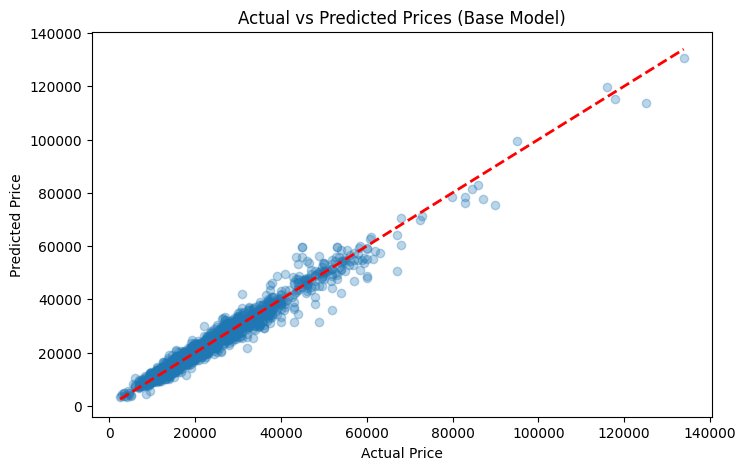

In [ ]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Đánh giá model trên tập test:
    - RMSE
    - R2 score
    - Biểu đồ Actual vs Predicted
    """
    print(f"\n--- Đánh giá {model_name} ---")

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"R2 Score (Hệ số xác định): {r2:.4f} (tương đương {r2*100:.2f}%)")

    plt.figure(figsize=(8,5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"Actual vs Predicted Prices ({model_name})")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.show()

evaluate_model(base_model, "Base Model", X_test, y_test)

## 7. Tuning Hyperparameter (RandomizedSearchCV)

Để cải thiện mô hình, nhóm dùng RandomizedSearchCV để tìm:
- n_estimators
- max_depth
- min_samples_split
- min_samples_leaf
- max_features

Chạy trên 3-fold cross validation.

Mục tiêu: tối ưu độ chính xác trong thời gian hợp lý.

In [ ]:
# ============================================================
# 7. HYPERPARAMETER TUNING
# ============================================================

def tune_model(X_train, y_train):
    """
    Tối ưu tham số Random Forest bằng RandomizedSearchCV.
    - Thử nhiều tổ hợp tham số ngẫu nhiên
    - Trả về model tốt nhất
    """
    print("\n--- 6. Hyperparameter Tuning ---")

    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 1.0]
    }

    rf_random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    print("Bắt đầu tìm tham số tốt nhất... (có thể mất vài phút)")
    rf_random_search.fit(X_train, y_train)

    print("Tuning hoàn tất.")
    print(f"Tham số tốt nhất tìm được: {rf_random_search.best_params_}")
    return rf_random_search.best_estimator_

# Hyperparameter tuning
tuned_model = tune_model(X_train, y_train)


--- 6. Hyperparameter Tuning ---
Bắt đầu tìm tham số tốt nhất... (có thể mất vài phút)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning hoàn tất.
Tham số tốt nhất tìm được: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 121}


## 8. Đánh giá mô hình đã tuning

Sau khi tối ưu, mô hình được đánh giá lại bằng:
- RMSE
- R²

Biểu đồ Actual vs Predicted

So sánh với base model để xem tuning có hiệu quả hay không.


--- Đánh giá Tuned Model ---
RMSE (Root Mean Squared Error): 2342.08
R2 Score (Hệ số xác định): 0.9637 (tương đương 96.37%)


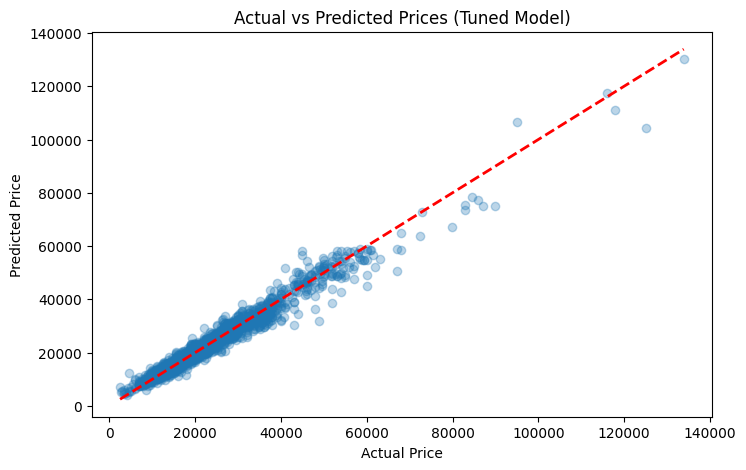

In [ ]:
evaluate_model(tuned_model, "Tuned Model", X_test, y_test)

## 9. Phân tích Feature Importance

Random Forest cho phép trích xuất độ quan trọng của từng đặc trưng.
Nhóm hiển thị top 15 đặc trưng quan trọng nhất giúp:
- Hiểu mô hình ra quyết định như thế nào
- Xác định biến nào ảnh hưởng mạnh nhất đến giá xe

Thông thường các biến quan trọng nhất là:
- year
- mileage
- engineSize
- một số mã model nhất định


--- 7. Feature Importance ---


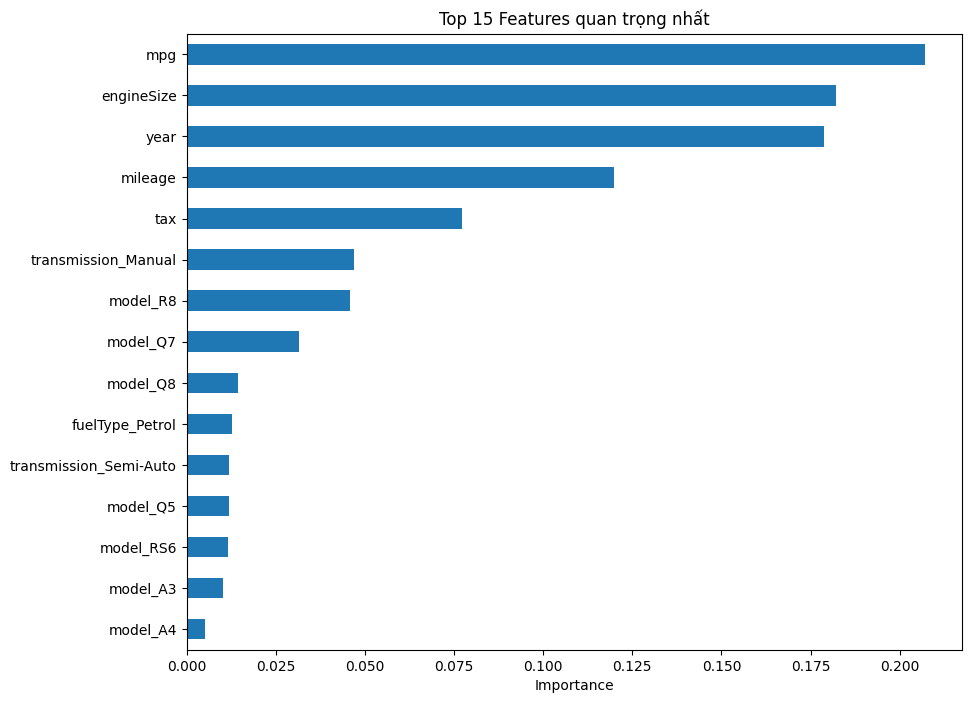

In [ ]:
# ============================================================
# 9. FEATURE IMPORTANCE
# ============================================================

def show_feature_importance(model, feature_names):
    """
    Vẽ biểu đồ top 15 features quan trọng nhất.
    """
    print("\n--- 7. Feature Importance ---")

    importances = model.feature_importances_
    feat_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10,8))
    feat_importance_df.head(15).plot(kind='barh')
    plt.title("Top 15 Features quan trọng nhất")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.show()

show_feature_importance(tuned_model, feature_names)

In [ ]:
print("\n--- ML Pipeline Complete ---")


--- ML Pipeline Complete ---
